<!-- Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Projetos de Análise de Dados com Linguagem Python</font>
# <font color='blue'>Projeto 6 - Regras de Associação e Market Basket Analysis</font>

## Pacotes Python Usados no Projeto

In [1]:
!pip install -q -U watermark

https://pypi.org/project/efficient-apriori/

In [2]:
!pip install -q efficient_apriori

In [3]:
# Imports
import numpy as np
import pandas as pd
import efficient_apriori
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



## Carregando os Dados

In [5]:
# Carrega os dados
dados_departamentos = pd.read_csv('departamentos.csv')
dados_corredores = pd.read_csv('corredores.csv')
dados_produtos = pd.read_csv('produtos.csv')
dados_pedidos = pd.read_csv('pedidos.csv')
dados_transacoes = pd.read_csv('transacoes.csv')

## Análise Exploratória

### Detalhes do Tamanho de Cada Dataset

In [6]:
# Total de registros por dataset
conta_arrays = np.array([['dados_departamentos', len(dados_departamentos)],
                        ['dados_corredores', len(dados_corredores)],
                        ['dados_produtos', len(dados_produtos)],
                        ['dados_pedidos', len(dados_pedidos)],
                        ['dados_transacoes', len(dados_transacoes)]])

In [7]:
# Converte o array em dataframe
contagem = pd.DataFrame(conta_arrays, columns = ['Arquivo', 'Total de Registros'])

In [8]:
print(contagem)

               Arquivo Total de Registros
0  dados_departamentos                 21
1     dados_corredores                134
2       dados_produtos              49688
3        dados_pedidos            3421083
4     dados_transacoes           32434489


In [9]:
dados_departamentos.shape

(21, 2)

In [10]:
dados_departamentos.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [11]:
dados_corredores.shape

(134, 2)

In [12]:
dados_corredores.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
dados_produtos.shape

(49688, 4)

In [14]:
dados_produtos.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [15]:
dados_pedidos.shape

(3421083, 7)

In [16]:
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
dados_transacoes.shape

(32434489, 4)

In [18]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Verificando Valores Ausentes

In [19]:
dados_departamentos.isna().sum()

department_id    0
department       0
dtype: int64

In [20]:
dados_corredores.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [21]:
dados_produtos.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [22]:
dados_pedidos.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [23]:
dados_transacoes.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

## Reorganização dos Dados

### Merge das Tabelas

In [24]:
%%time
dados_transacoes = dados_transacoes.merge(dados_pedidos, on = 'order_id', how = 'left')
dados_transacoes = dados_transacoes.merge(dados_produtos, on = 'product_id', how = 'left')
dados_transacoes = dados_transacoes.merge(dados_corredores, on = 'aisle_id', how = 'left')
dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'department_id', how = 'left')

CPU times: user 6.25 s, sys: 2.26 s, total: 8.51 s
Wall time: 8.6 s


In [25]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [26]:
dados_transacoes.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [27]:
dados_transacoes.isnull().sum() / len(dados_transacoes) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos manter a variável days_since_prior_order por duas razões:

1- O percentual de valores ausentes é apenas de 6.4%.

2- Não usaremos a variável com o algoritmo MBA.

> Vamos agrupar os dados para aplicar o algoritmo Apriori e preparar o dataset com todas as transações.

In [28]:
%%time
df_dsa = pd.DataFrame(dados_transacoes.groupby('order_id')['product_id'])

CPU times: user 47.1 s, sys: 954 ms, total: 48.1 s
Wall time: 48.1 s


In [29]:
df_dsa.shape

(3214874, 2)

In [30]:
df_dsa.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [31]:
# Lista
prod = []

In [32]:
%%time
for i in range(len(df_dsa[0])):
    prod.append(list(df_dsa.iloc[i][1]))

CPU times: user 32.7 s, sys: 212 ms, total: 32.9 s
Wall time: 33 s


In [33]:
prod_ = prod

In [34]:
order_ = df_dsa[0]

In [35]:
# Prepara o dataframe
transactions = pd.DataFrame({'Id_Pedido' : order_, 'Produtos' : prod_})

In [36]:
transactions.head(10)

,Id_Pedido,Produtos
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


## Agora é Com Você!

Responda as perguntas abaixo através de resumos, tabelas e gráficos.

### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

### 4- Qual Departamento Tem o Maior Número de Pedidos?

### 5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

### 7- Faça a Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (Reorder)

### 8- Faça a Análise de Reorder Por Departamento ao Longo do Tempo

### 9- Faça a Análise de Reorder e Pedidos

### 10- Faça a Análise de Reorder Por Corredor

### 10.1- Faça a Análise de Reorder Por Corredor (Total)

As soluções serão apresentadas no próximo capítulo.

## Análise Estatística Descritiva

### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [37]:
# Amostra aleatória de dados
dados_pedidos.sample(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
405050,530492,24373,prior,32,5,23,10.0
3311216,1934248,199606,prior,2,3,16,30.0
2569175,1621962,154582,prior,1,4,10,NaN
2452369,1178117,147589,prior,9,5,20,20.0
2340170,2442653,140887,prior,5,3,11,3.0
2512611,1357427,151278,prior,32,5,16,7.0
604831,2877754,36481,prior,6,6,14,4.0
557208,1405298,33586,prior,34,0,11,2.0
3398689,406920,204815,prior,2,1,15,29.0
1909866,2514117,114688,prior,22,1,14,4.0


In [38]:
# Agrupa os dados por usuário agregando pelo maior valor de order_number
contagem_maxima_pedido = dados_pedidos.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
contagem_maxima_pedido.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


Compreendendo o Código Anterior:

**order.groupby("user_id")**: Este comando agrupa o DataFrame order pela coluna "user_id". Isso significa que todas as linhas com o mesmo valor em user_id são consideradas juntas em um grupo. A operação de agrupamento é preparatória para realizar alguma operação de agregação dentro de cada grupo.

**['order_number'].aggregate(np.max)**: Depois de agrupar os dados por user_id, selecionamos a coluna 'order_number' desses grupos. Então, usamos a função aggregate com np.max (que é a função de máximo do NumPy) para calcular o maior valor de 'order_number' dentro de cada grupo. Em outras palavras, para cada usuário, estamos encontrando o maior número de pedidos.

**.reset_index()**: Este método é usado para resetar o índice do DataFrame. Quando realizamos uma operação de agrupamento, o pandas transforma as colunas pelas quais agrupamos (neste caso, user_id) em índices no novo DataFrame. Usar reset_index() move user_id de volta para uma coluna regular e cria um novo índice numérico padrão.

In [39]:
# Frequência de cada valor de número de pedidos
contagem_maxima_pedido = contagem_maxima_pedido.order_number.value_counts()
contagem_maxima_pedido.head()

order_number
4    23986
5    19590
6    16165
7    13850
8    11700
Name: count, dtype: int64

Agora plugamos os dados no gráfico:

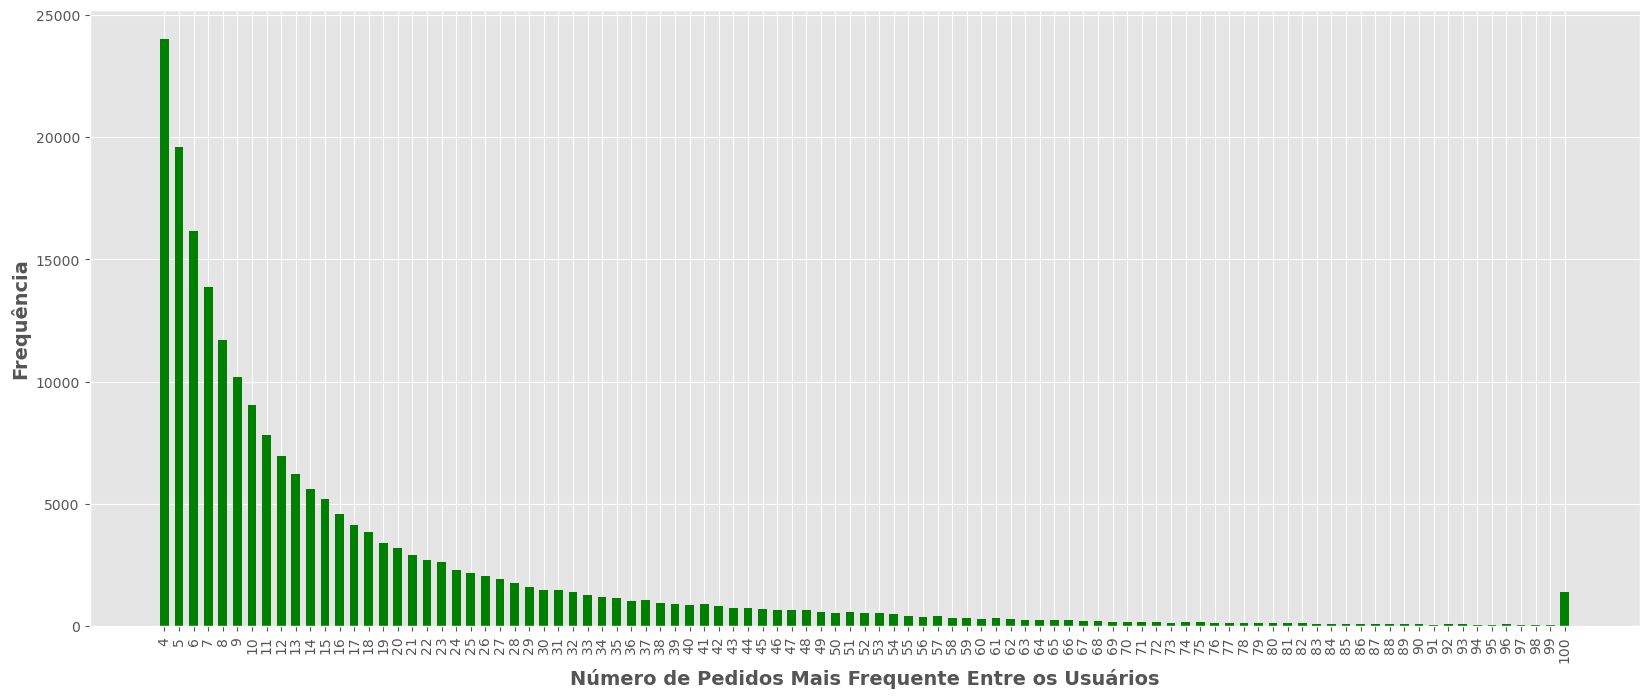

In [40]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(contagem_maxima_pedido.index, contagem_maxima_pedido.values, color = 'green', width = 0.6)
plt.xticks(contagem_maxima_pedido.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [41]:
# (dow = day of the week)
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [42]:
# Contagem de frequência (ocorrência) de cada valor de order_dow
dados_pedidos.order_dow.value_counts()

order_dow
0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: count, dtype: int64

Vamos preparar x e y para o gráfico no formato de listas Python.

In [43]:
# Índice para os dias da semana
x = [0,1,2,3,4,5,6]

In [44]:
# Frequências de pedidos pelo índice (dia da semana)
y = dados_pedidos['order_dow'].value_counts().sort_index().tolist()

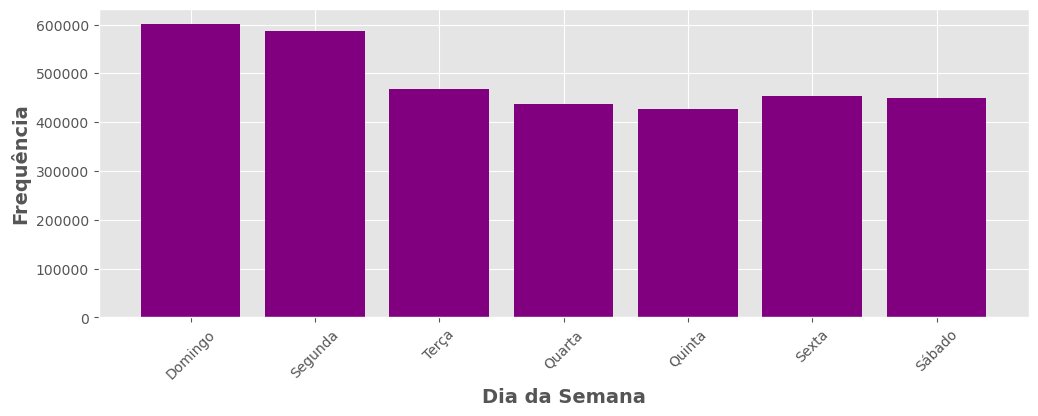

In [45]:
# Plot
plt.figure(figsize = (12,4))
plt.bar(x, y, color = 'purple')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x, ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 45)
plt.show()

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [46]:
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


> Solução 1 com Recursos da Linguagem Python

In [47]:
# Frequências de pedidos pela hora do dia
x1 = list(range(0,24))
print(x1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [48]:
# Frequências de pedidos pela hora do dia
y1 = []
for i in range(0,24):
    y1.append(dados_pedidos[dados_pedidos['order_hour_of_day']==i].shape[0])
print(y1)

[22758, 12398, 7539, 5474, 5527, 9569, 30529, 91868, 178201, 257812, 288418, 284728, 272841, 277999, 283042, 283639, 272553, 228795, 182912, 140569, 104292, 78109, 61468, 40043]


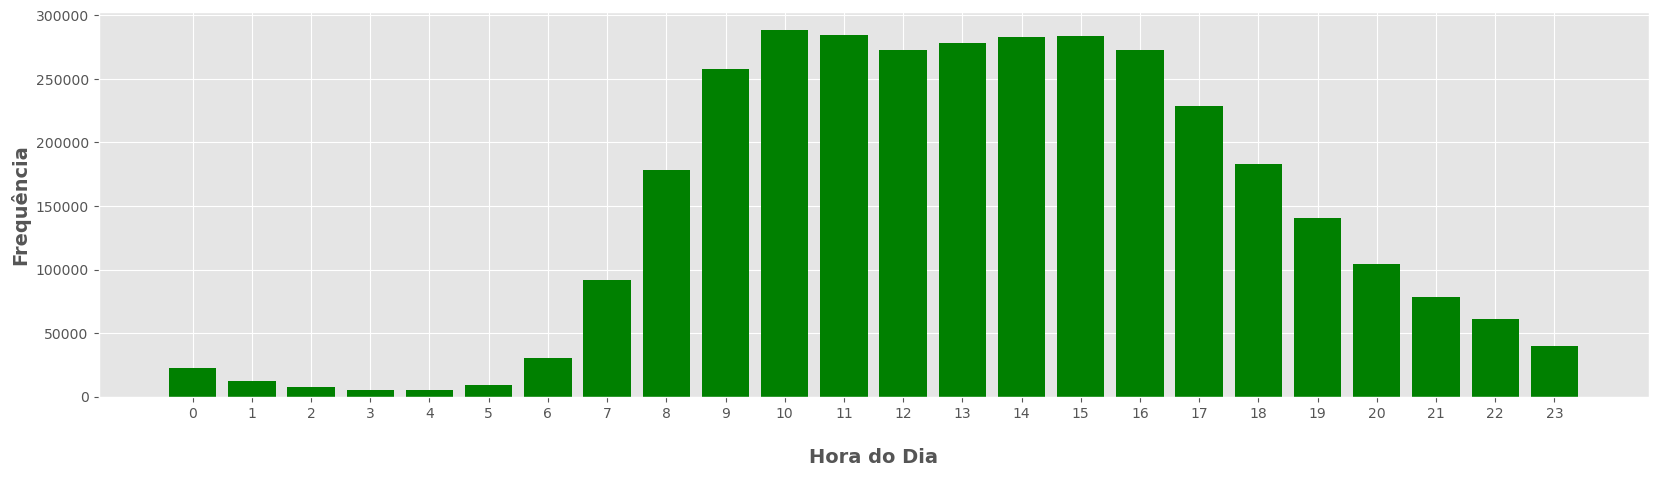

In [49]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x1, y1, color = 'green')
plt.xticks(np.arange(0,24,1))
plt.xlabel('\nHora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

> Solução 2 com Recursos do Pandas

In [50]:
# Agrupar por hora do dia e contar os pedidos
frequencia_por_hora = dados_pedidos.groupby('order_hour_of_day').size()
frequencia_por_hora.head()

order_hour_of_day
0    22758
1    12398
2     7539
3     5474
4     5527
dtype: int64

In [51]:
frequencia_por_hora.head(24)

order_hour_of_day
0      22758
1      12398
2       7539
3       5474
4       5527
5       9569
6      30529
7      91868
8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
21     78109
22     61468
23     40043
dtype: int64

In [52]:
# Extrair horas e contagens para as listas x e y
x2 = frequencia_por_hora.index.tolist()
y2 = frequencia_por_hora.values.tolist()

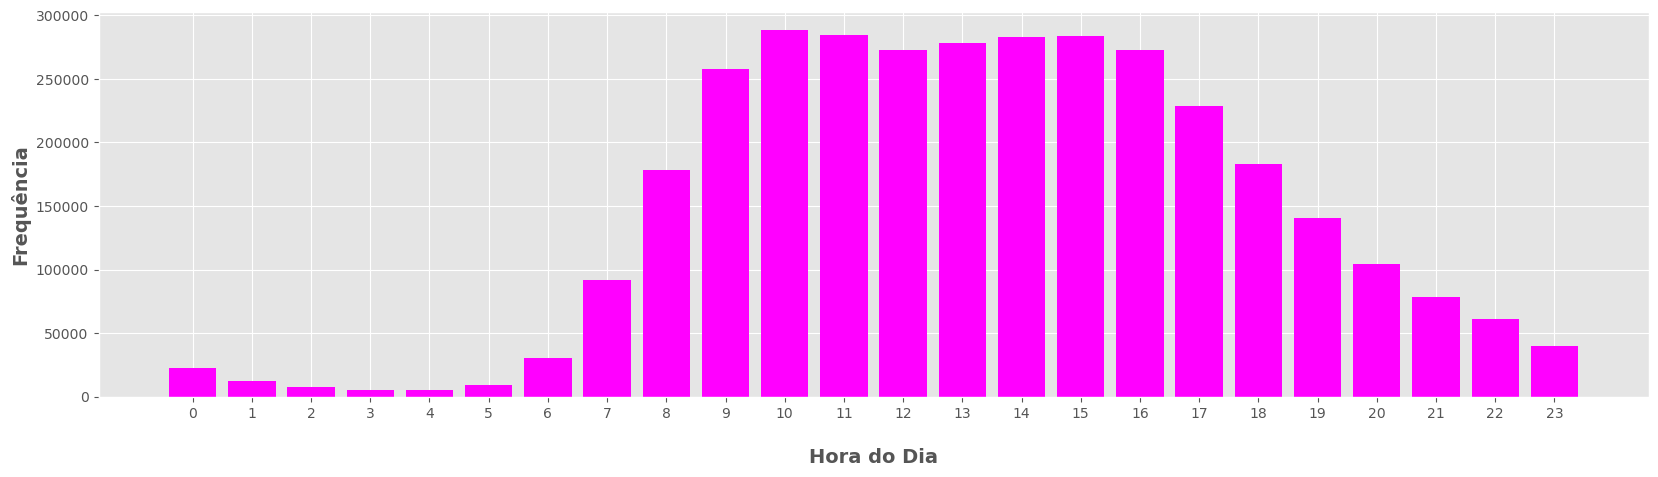

In [53]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x2, y2,color = 'magenta')
plt.xticks(np.arange(0,24,1))
plt.xlabel('\nHora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 4- Qual Departamento Tem o Maior Número de Pedidos?

In [54]:
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [55]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [56]:
# Contagem de pedidos por departamento
contagem_departamento = dados_transacoes['department'].value_counts()
contagem_departamento.head()

department
produce       9479291
dairy eggs    5414016
snacks        2887550
beverages     2690129
frozen        2236432
Name: count, dtype: int64

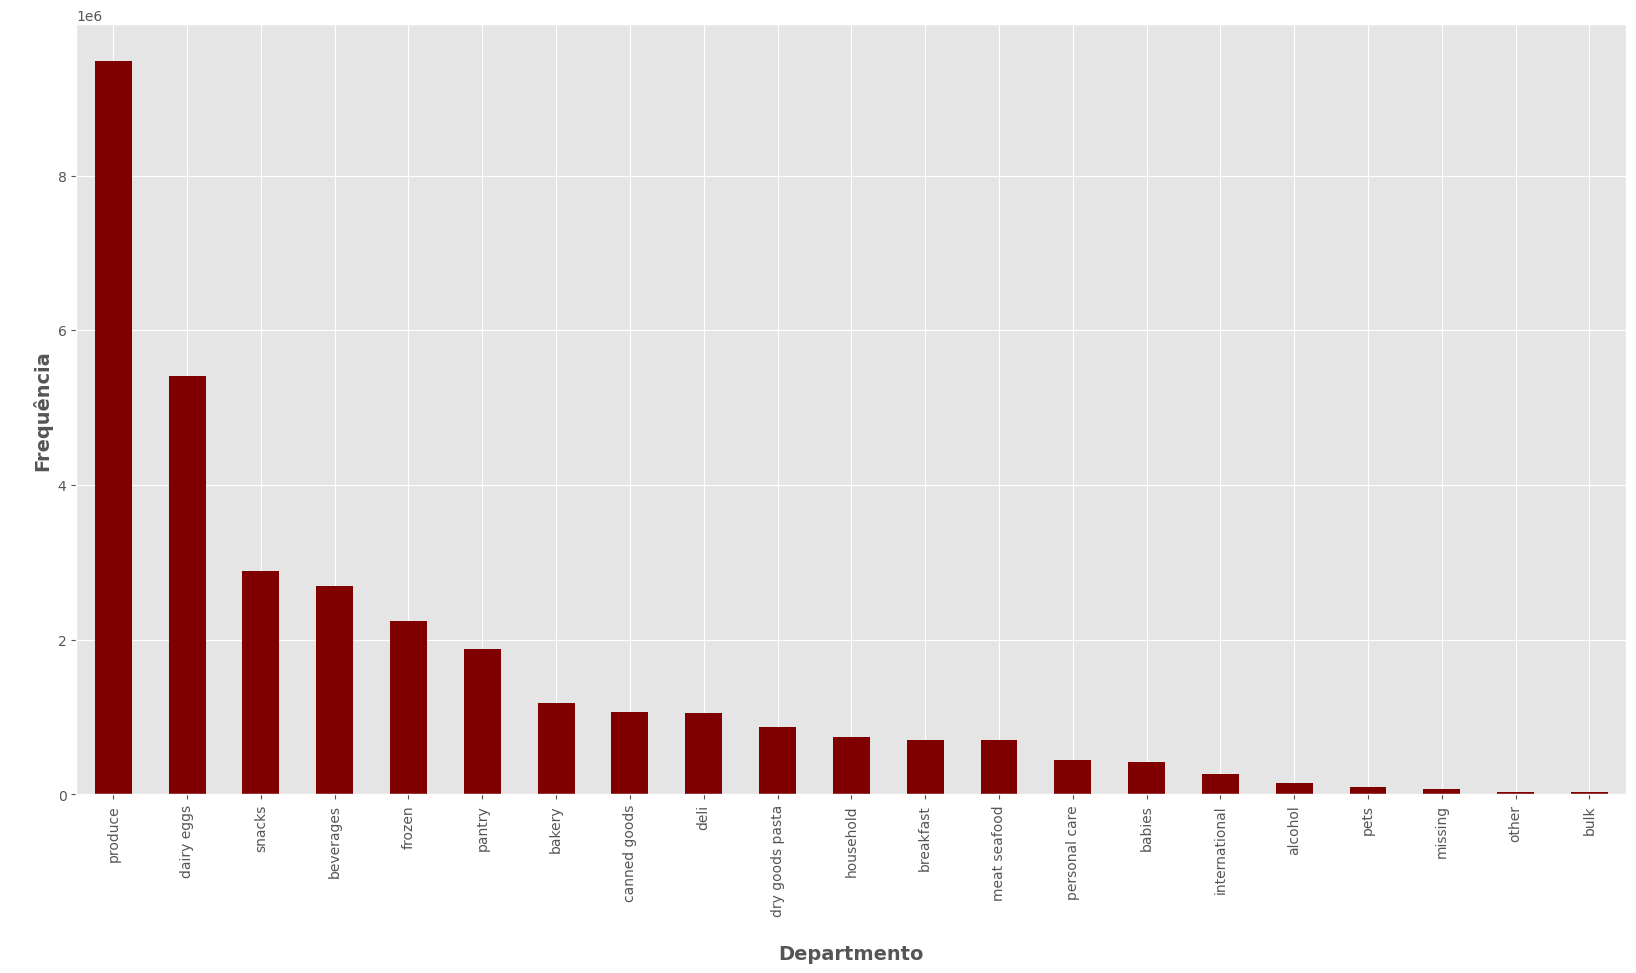

In [57]:
# Plot
fig = plt.figure(figsize = (20,10))
contagem_departamento.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('\nDepartmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('\nFrequência', fontsize = 14, fontweight = 'bold')
plt.show()

A solução acima funciona pois a tabela dados_transacoes possui o nome dos departamentos. Se fosse necessário buscar o nome em outra tabela, a solução seria diferente:

In [58]:
# Unir dados_transacoes com dados_produtos
# Aqui, suffixes é usado para diferenciar as colunas com o mesmo nome
transacoes_produtos = pd.merge(dados_transacoes, dados_produtos, on='product_id', suffixes=('', '_produto'))
transacoes_produtos.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,product_name_produto,aisle_id_produto,department_id_produto
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16


In [59]:
# Agora, vamos usar a coluna 'department_id' apropriada para o próximo merge
# Garantindo que estamos usando 'department_id' do DataFrame dados_produtos
transacoes_departamentos = pd.merge(transacoes_produtos, dados_departamentos, on='department_id')
transacoes_departamentos.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department_x,product_name_produto,aisle_id_produto,department_id_produto,department_y
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs


In [60]:
# Contar as transações por departamento
contagem_departamentos = transacoes_departamentos['department_x'].value_counts()
contagem_departamentos.head()

department_x
produce       9479291
dairy eggs    5414016
snacks        2887550
beverages     2690129
frozen        2236432
Name: count, dtype: int64

In [61]:
# Encontrar o departamento com o maior número de pedidos
departamento_mais_pedidos = contagem_departamentos.idxmax()

In [62]:
print(departamento_mais_pedidos)

produce


### 5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [63]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [64]:
# Os 20 principais corredores e sua frequência de pedidos
contagem = dados_transacoes['aisle'].value_counts()

In [65]:
contagem[0:20]

aisle
fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
Name: count, dtype: int64

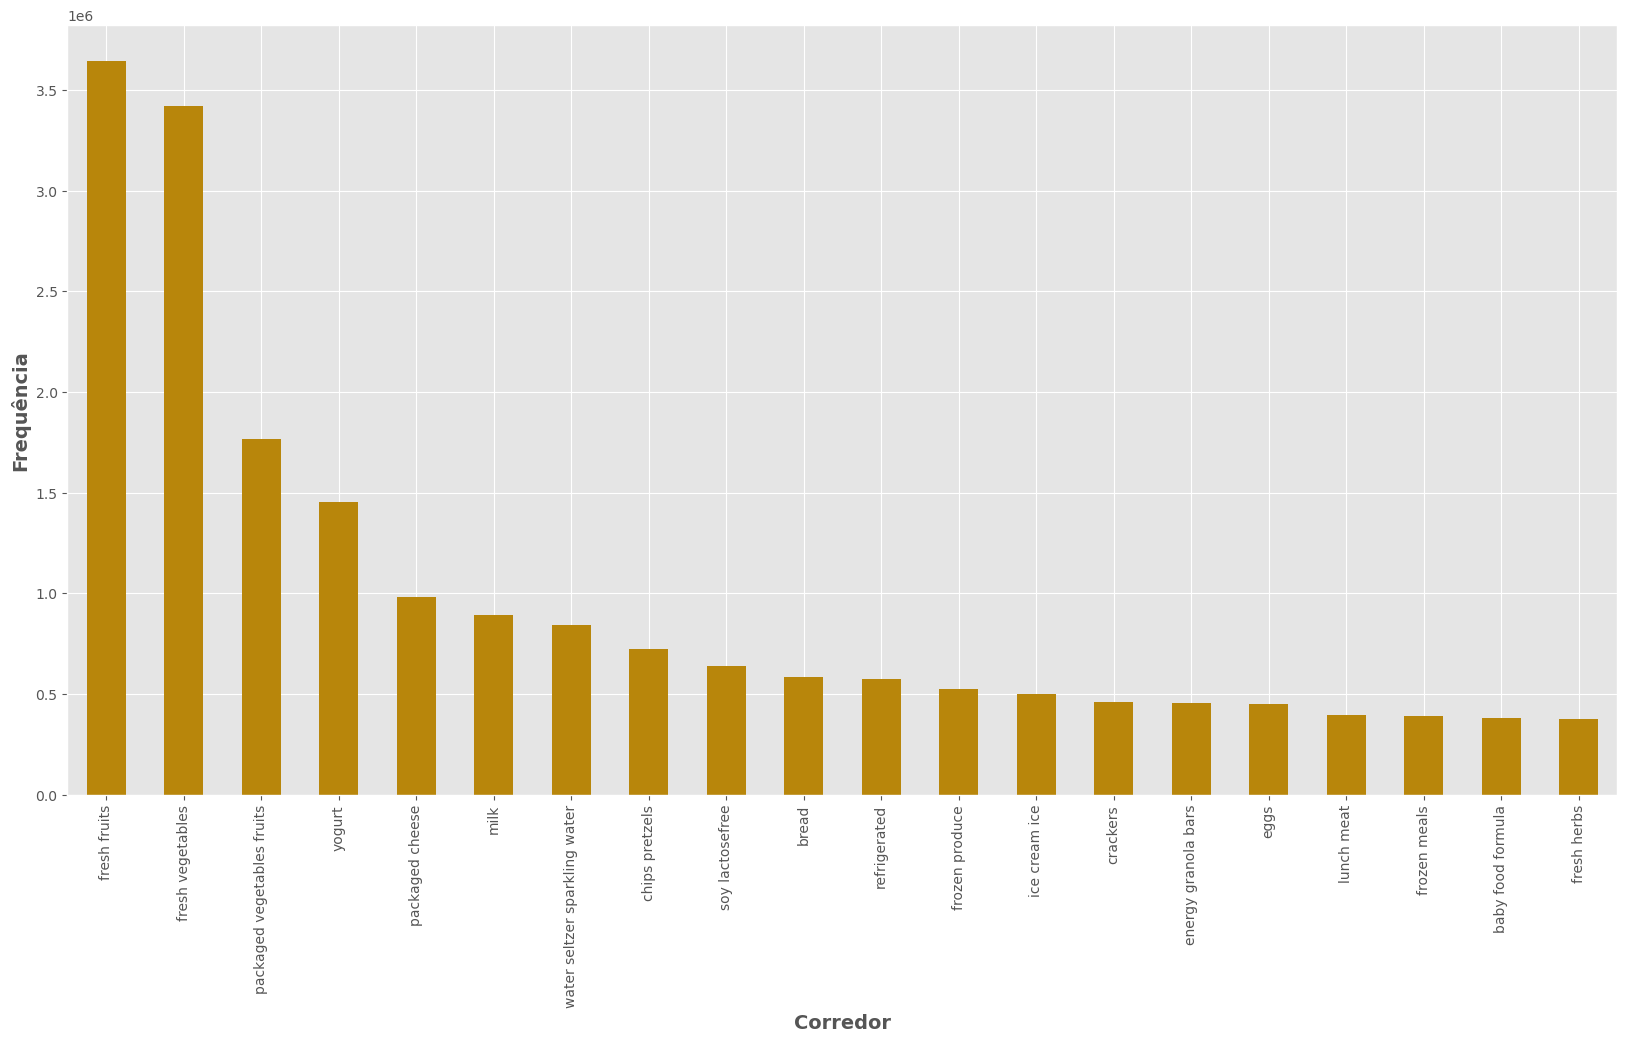

In [66]:
# Plot
fig = plt.figure(figsize = (20,10))
contagem[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

Mesmo caso do item 4. Por acaso os dados estão todos na tabela dados_transacoes. Se não estivessem, teríamos que fazer merge como o exemplo abaixo:

In [67]:
# Contar a frequência de cada produto em dados_transacoes
frequencia_produtos = dados_transacoes['product_id'].value_counts()

# Criar um dicionário para mapear product_id para aisle_id
produto_para_corredor = dict(zip(dados_produtos['product_id'], dados_produtos['aisle_id']))

# Criar um dicionário para mapear aisle_id para o nome do corredor
id_para_nome_corredor = dict(zip(dados_corredores['aisle_id'], dados_corredores['aisle']))

# Calcular a frequência de cada corredor
frequencia_corredores = {}
for produto, freq in frequencia_produtos.items():
    corredor_id = produto_para_corredor.get(produto)
    if corredor_id:
        corredor_nome = id_para_nome_corredor.get(corredor_id, "Corredor Desconhecido")
        frequencia_corredores[corredor_nome] = frequencia_corredores.get(corredor_nome, 0) + freq

# Ordenar os corredores por frequência e pegar os 20 principais
principais_corredores = sorted(frequencia_corredores.items(), key=lambda x: x[1], reverse=True)[:20]

# Exibir os 20 principais corredores
for corredor, freq in principais_corredores:
    print(f"Corredor: {corredor}, Frequência: {freq}")

Corredor: fresh fruits, Frequência: 3642188
Corredor: fresh vegetables, Frequência: 3418021
Corredor: packaged vegetables fruits, Frequência: 1765313
Corredor: yogurt, Frequência: 1452343
Corredor: packaged cheese, Frequência: 979763
Corredor: milk, Frequência: 891015
Corredor: water seltzer sparkling water, Frequência: 841533
Corredor: chips pretzels, Frequência: 722470
Corredor: soy lactosefree, Frequência: 638253
Corredor: bread, Frequência: 584834
Corredor: refrigerated, Frequência: 575881
Corredor: frozen produce, Frequência: 522654
Corredor: ice cream ice, Frequência: 498425
Corredor: crackers, Frequência: 458838
Corredor: energy granola bars, Frequência: 456386
Corredor: eggs, Frequência: 452134
Corredor: lunch meat, Frequência: 395130
Corredor: frozen meals, Frequência: 390299
Corredor: baby food formula, Frequência: 382456
Corredor: fresh herbs, Frequência: 377741


### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [68]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [69]:
# Os 20 principais produtos por frequência de pedido
contagem_produtos = dados_transacoes['product_name'].value_counts()

In [70]:
contagem_produtos.head()

product_name
Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Name: count, dtype: int64

In [71]:
contagem_produtos[0:20]

product_name
Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: count, dtype: int64

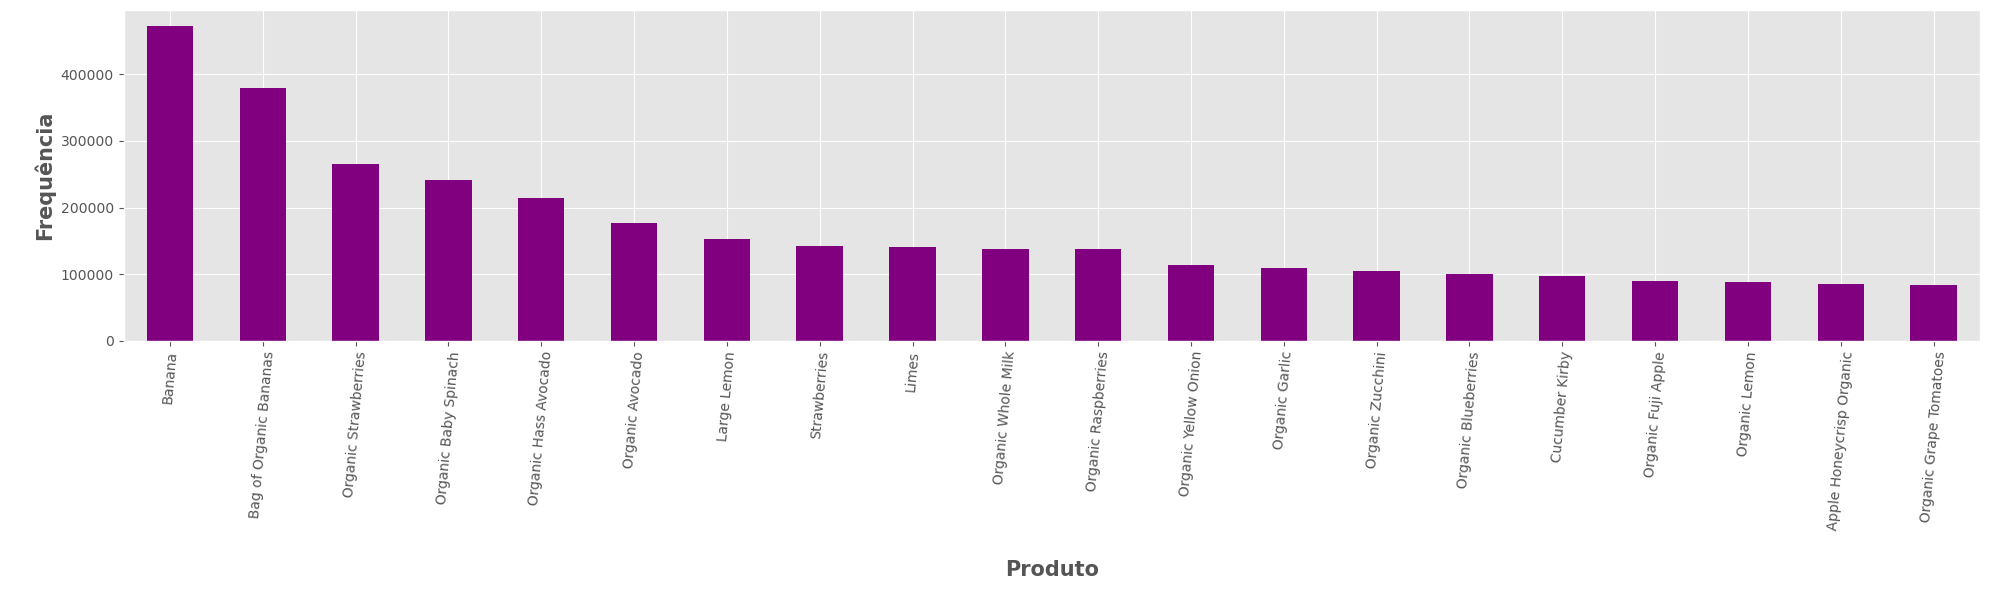

In [72]:
# Plot
fig = plt.figure(figsize = (20,6))
contagem_produtos[0:20].plot(kind = "bar", color = 'purple')
plt.xticks(rotation = 85)
plt.xlabel('\nProduto', fontsize = 15, fontweight = 'bold')
plt.ylabel('\nFrequência', fontsize = 15, fontweight = 'bold')
plt.tight_layout()
plt.show()

### 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

Vamos agrupar os dados e obter contagem e soma.

In [73]:
%%time
df_temp1 = dados_transacoes.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
df_temp1 = df_temp1.sort_values('total', ascending = False).reset_index()


CPU times: user 1.97 s, sys: 45.1 ms, total: 2.02 s
Wall time: 1.62 s


Este trecho de código acima está usando a biblioteca Pandas para manipular um DataFrame chamado dados_transacoes. 

Aqui está o que cada parte do código faz:

**dados_transacoes.groupby("product_name")["reordered"]**: Isso agrupa o DataFrame dados_transacoes pelo valor da coluna "product_name" e depois seleciona a coluna "reordered" para futuras operações.

**.agg(['count', 'sum'])**: Isso aplica duas funções de agregação, count e sum, à coluna "reordered" para cada grupo (cada produto único). A função count conta o número de vezes que cada produto aparece no DataFrame (ou seja, a frequência do produto) e a função sum soma os valores da coluna "reordered" para cada grupo, que indica a quantidade de vezes que o produto foi reordenado.

**.rename(columns = {'count':'total','sum':'reorders'})**: Isso renomeia as colunas resultantes da agregação para "total" (anteriormente "count") e "reorders" (anteriormente "sum"), para tornar os nomes das colunas mais descritivos.

**df_temp1 = ...**: O resultado das operações acima é atribuído a um novo DataFrame chamado df_temp1.

**df_temp1.sort_values('total', ascending = False)**: Isso ordena o DataFrame df_temp1 pela coluna "total" em ordem decrescente. Isso significa que os produtos com as maiores frequências (ou seja, os mais comuns) aparecerão primeiro.

**.reset_index()**: Isso redefine o índice do DataFrame resultante, de modo que o índice seja uma sequência numérica simples (começando em 0). Isso é útil após a ordenação, pois garante que o índice reflita a nova ordem dos dados.

In [74]:
# Prepara as listas com os 20 top registros (para não poluir o gráfico)
labels = list(df_temp1.product_name[0:20])
reorder = list(df_temp1.reorders[0:20])
total = list(df_temp1.total[0:20])    

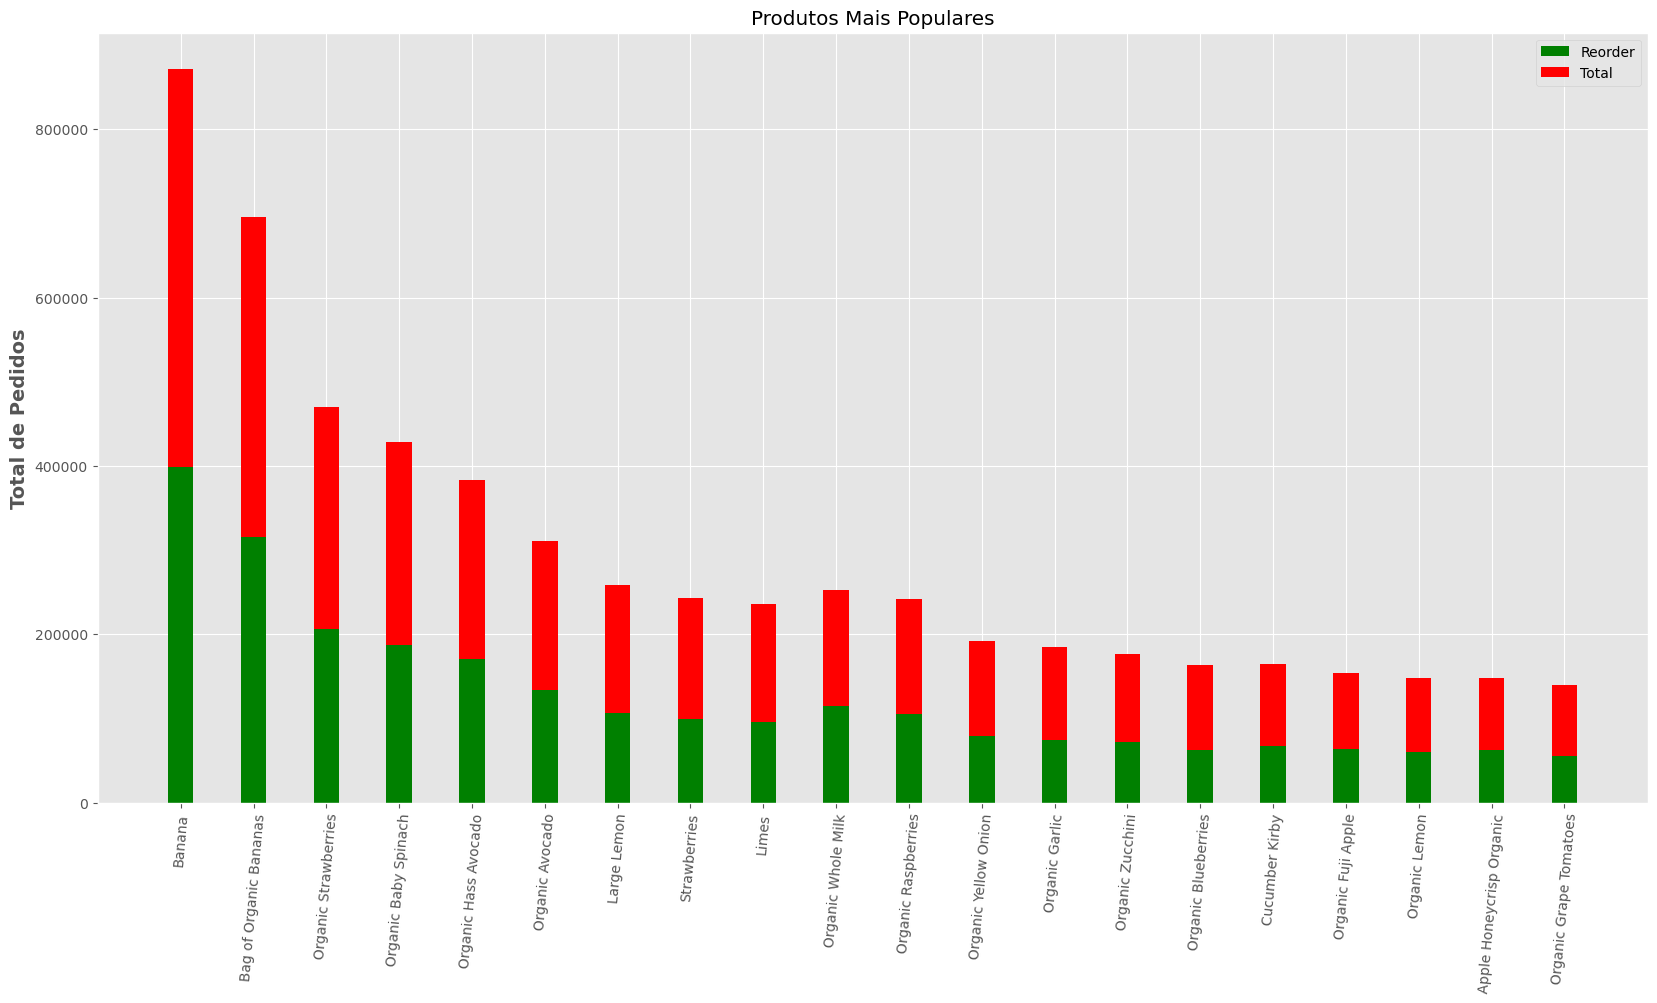

In [75]:
# Plot  
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 85)
plt.show()

### 8- Análise de Reorder Por Departamento ao Longo do Tempo

In [76]:
# Agrupando os dados por departamento e reorder
df_temp2 = dados_transacoes.groupby(["department"])["reordered"].aggregate("mean").reset_index()
df_temp2.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


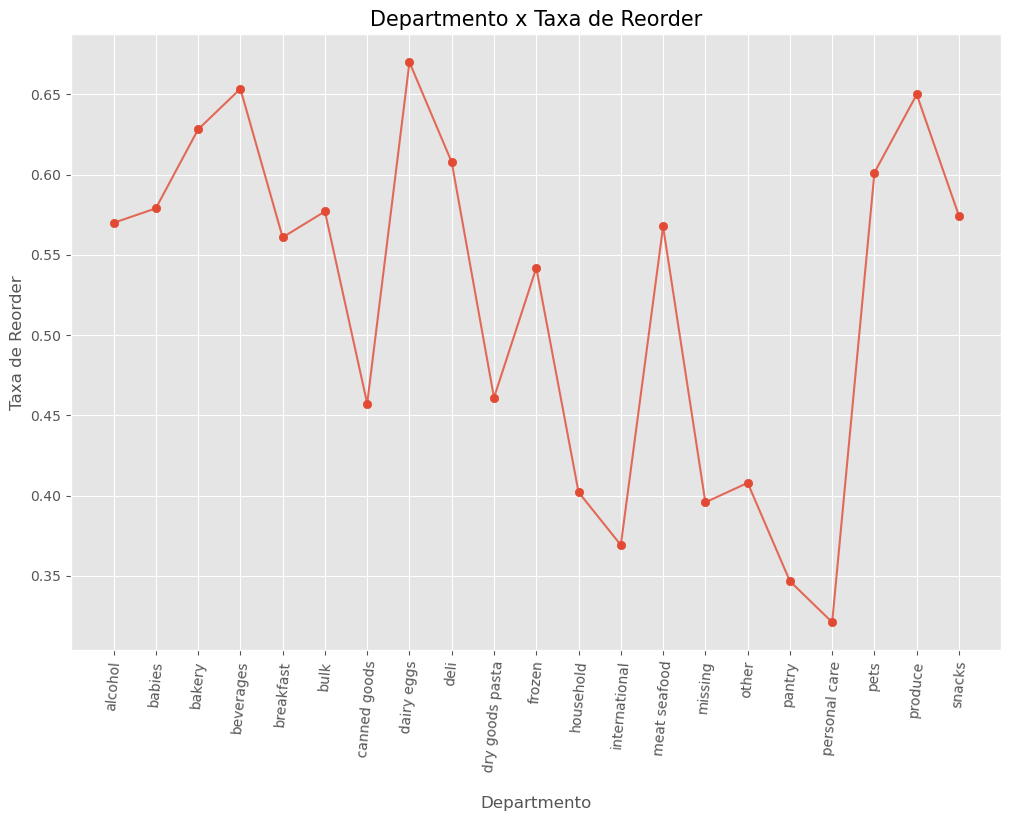

In [77]:
# Plot
plt.figure(figsize = (12,8))
plt.plot(list(df_temp2['department']), df_temp2['reordered'].values, alpha=0.8)
plt.scatter(list(df_temp2['department']), df_temp2['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('\nDepartmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 85)
plt.show()

### 9- Análise de Reorder e Pedidos

Agrupamos os dados por departamento e por reorder.

In [78]:
%%time
df_temp3 = dados_transacoes.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
df_temp3 = df_temp3.sort_values('total', ascending = False).reset_index()

CPU times: user 1.24 s, sys: 44.5 ms, total: 1.29 s
Wall time: 896 ms


O objetivo geral deste trecho de código acima é agrupar os dados de transações por departamento, calcular o total de ocorrências e a soma de reordenações para cada departamento, renomear as colunas resultantes para serem mais descritivas, ordenar os departamentos pela frequência total em ordem decrescente e, por fim, redefinir o índice do DataFrame resultante.

In [79]:
df_temp3.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [80]:
# Listas
labels = list(df_temp3.department[0:20])
reorder = list(df_temp3.reorders[0:20])
total = list(df_temp3.total[0:20])

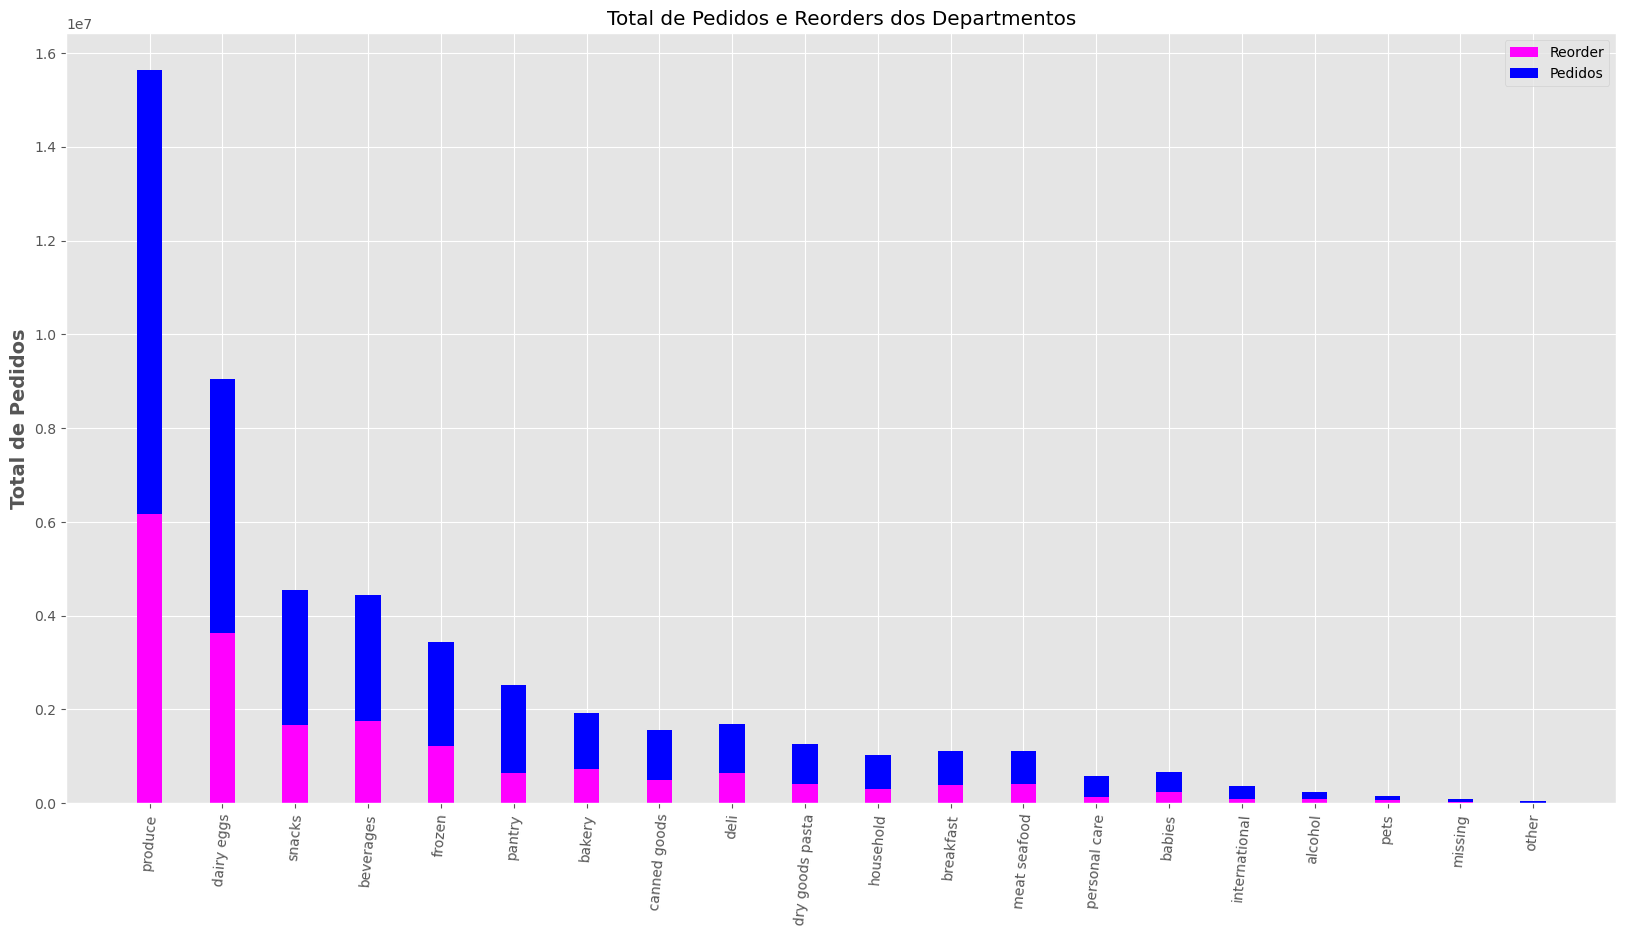

In [81]:
# Plot
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 85)
plt.show()

### 10- Análise de Reorder Por Corredor

In [82]:
%%time
df_temp4 = dados_transacoes.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
df_temp4.head()

CPU times: user 1.29 s, sys: 48.3 ms, total: 1.34 s
Wall time: 998 ms


,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [83]:
# Lista os 20 primeiros
list(df_temp4['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

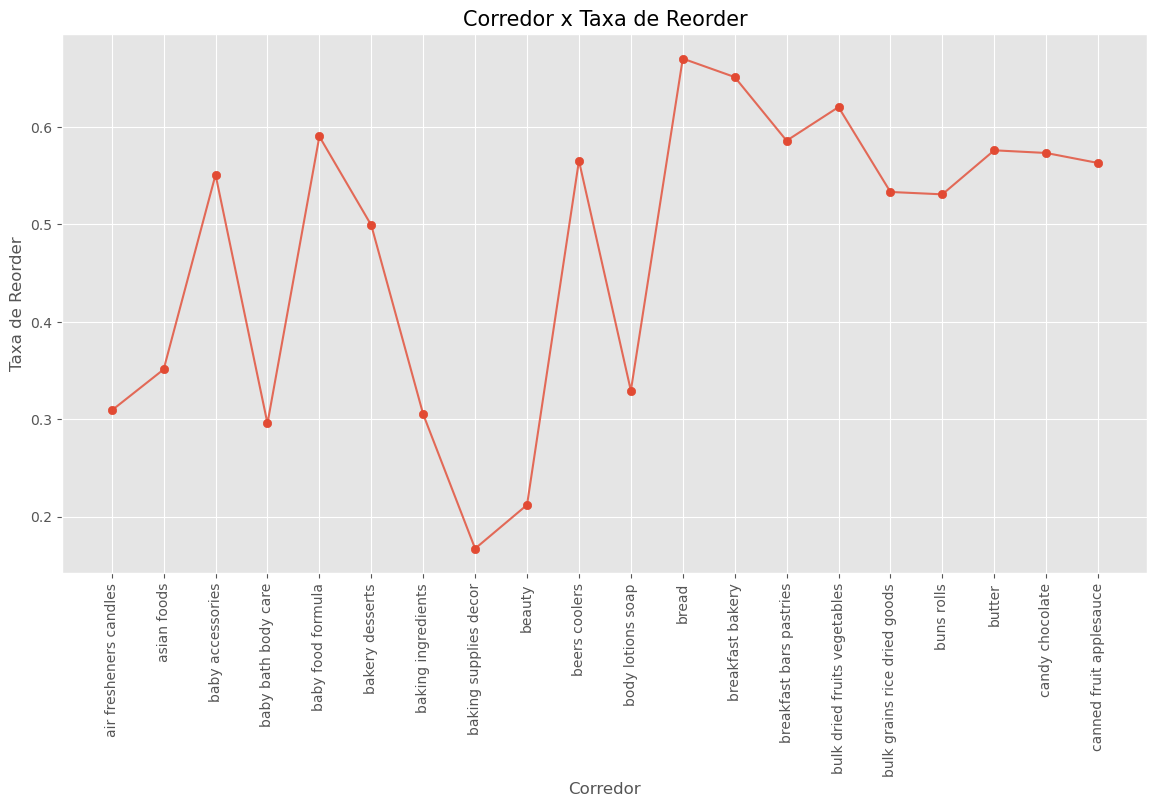

In [84]:
# Corredor x Taxa de Reorder
plt.figure(figsize=(14,7))
plt.plot(list(df_temp4['aisle'])[0:20], df_temp4['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(df_temp4['aisle'])[0:20], df_temp4['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 10.1- Análise de Reorder Por Corredor (Total)

In [85]:
%%time
df_temp5 = dados_transacoes.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
df_temp5 = df_temp5.sort_values('total', ascending = False).reset_index()


CPU times: user 1.36 s, sys: 42 ms, total: 1.4 s
Wall time: 1.01 s


O objetivo geral deste trecho de código acima é agrupar os dados de transações por corredor, calcular o total de ocorrências e a soma de reordenações para cada corredor, renomear as colunas resultantes para serem mais descritivas, ordenar os corredores pela frequência total em ordem decrescente e, por fim, redefinir o índice do DataFrame resultante.

In [86]:
df_temp5.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [87]:
# Listas
labels = list(df_temp5.aisle[0:20])
reorder = list(df_temp5.reorders[0:20])
total = list(df_temp5.total[0:20])

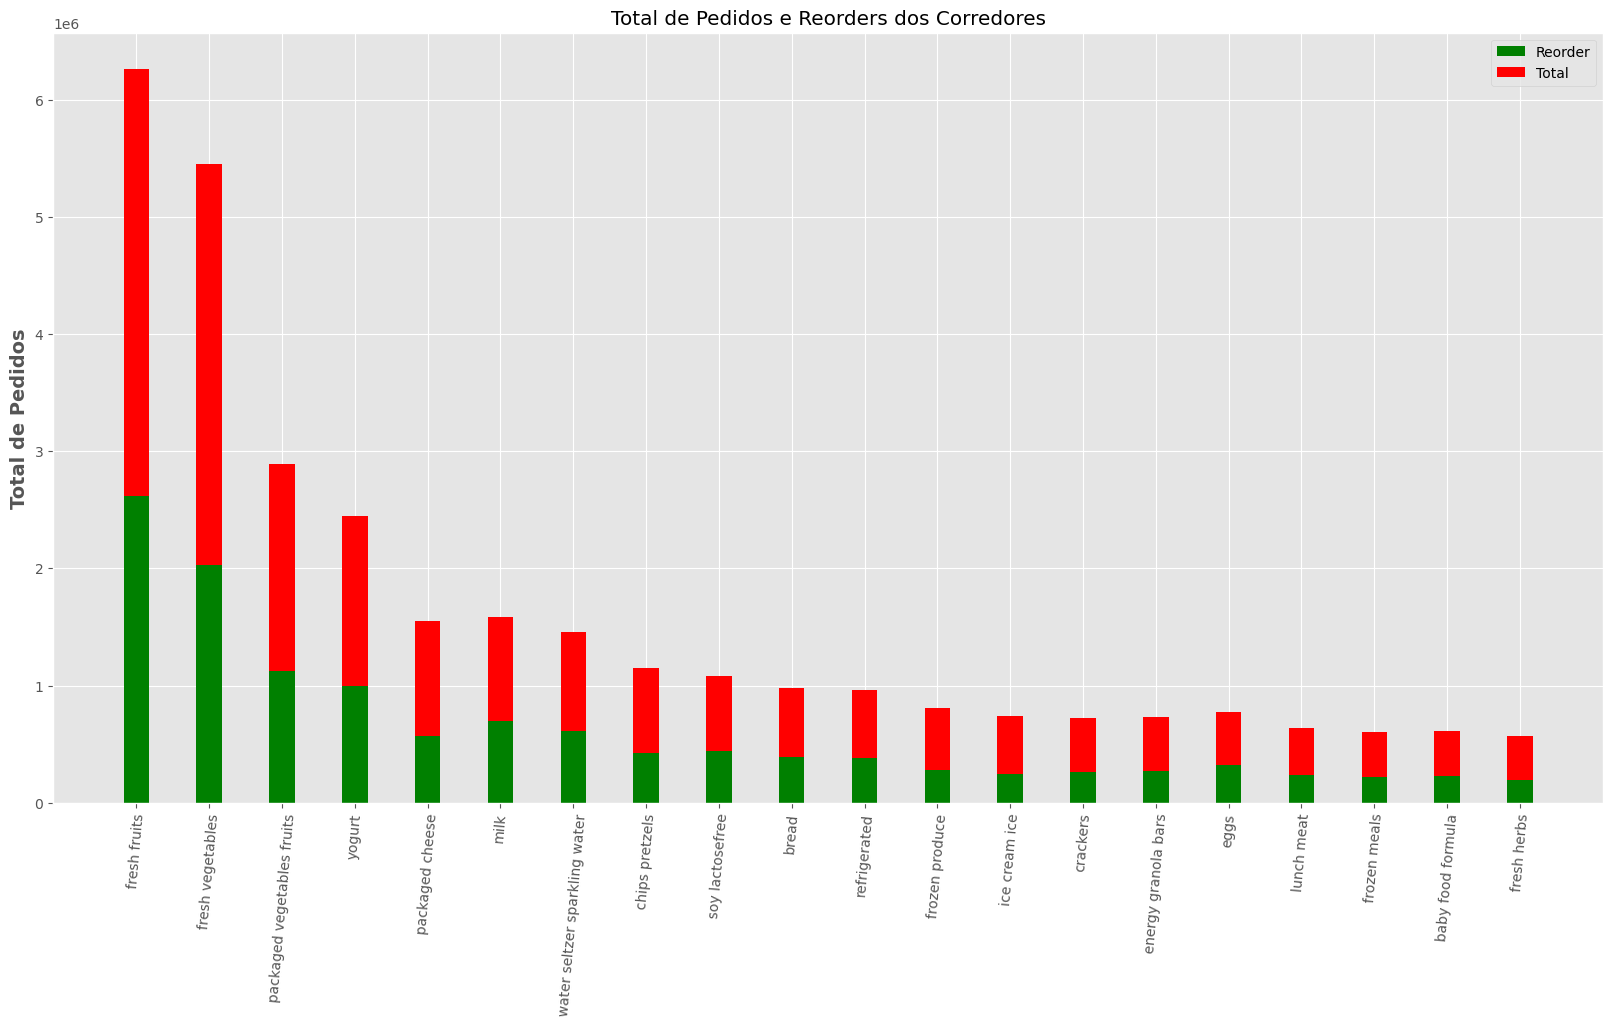

In [88]:
# Plot
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 85)
plt.show()

> Vamos verificar a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [89]:
# Cria uma cópia de uma das colunas
dados_transacoes["add_to_cart_order_mod"] = dados_transacoes["add_to_cart_order"].copy()

In [90]:
# Localiza as transações
dados_transacoes["add_to_cart_order_mod"].loc[dados_transacoes["add_to_cart_order_mod"] > 70] = 70

In [91]:
# Calcula a média e faz o reset do índice
grouped_df = dados_transacoes.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

In [92]:
grouped_df.head(10)

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
5,6,0.600420
6,7,0.585687
7,8,0.573247
8,9,0.561474
9,10,0.551018


<!-- Data Science Academy - www.datascienceacademy.com.br -->
## Implementação do Algoritmo Apriori

O algoritmo Apriori é utilizado para análise de associação de regras, que é comumente usada em mineração de dados para descobrir relações entre variáveis em grandes bases de dados. Neste contexto, ele é usado para encontrar padrões de compra frequentes, ou seja, quais produtos são frequentemente comprados juntos. 

In [93]:
transactions.head()

,Id_Pedido,Produtos
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"


In [94]:
# Prepara a tupla com as transações
transactions_tup = [tuple(row) for row in transactions['Produtos'].tolist()]

Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

Vamos usar os 500000 primeiros registros para evitar sobrecarga de processamento.

In [95]:
%%time
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)

CPU times: user 1.33 s, sys: 34.7 ms, total: 1.36 s
Wall time: 1.36 s


In [96]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [97]:
# Vamos considerar alguns itens para nossa análise
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [98]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [99]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [100]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(dados_produtos, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(dados_produtos, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [101]:
df_rules_ap

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
2,Organic Strawberries,Banana,0.082550,0.147194,0.017596,0.213156,1.448127
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


Veja a interpretação completa da tabela no videobook.

In [102]:
# Ordenando pela Confidence
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [103]:
# Ordenando pelo Lift
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


### Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2

In [104]:
%%time
itemsets_ap_1, rules_ap_1 = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)

CPU times: user 2.71 s, sys: 41.4 ms, total: 2.75 s
Wall time: 2.75 s


In [105]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [106]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [107]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [108]:
# Loop
for i in range(len(temp1)):
    
    support_A1.append(itemsets_ap_1[1][tuple([temp1['itemA'][i],])] / 500000)
    
    support_B1.append(itemsets_ap_1[1][tuple([temp1['itemB'][i],])] / 500000)
    
    if tuple([temp1['itemA'][i],temp1['itemB'][i]]) in itemsets_ap_1[2].keys():
        
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemA'][i],temp1['itemB'][i]])] / 500000)
    
    else:
        
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemB'][i],temp1['itemA'][i]])] / 500000)
    
    confidence_AB1.append(support_AB1[i] / support_A1[i])
    
    lift_AB1.append(support_AB1[i] / (support_A1[i] * support_B1[i]))

In [109]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(dados_produtos, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(dados_produtos, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [110]:
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


In [111]:
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


## Conclusão

Aplicando Matemática e Estatística via programação executamos uma análise de MBA gerando como resultado as regras de associação entre os produtos com diferentes métricas. Podemos agora levar nossas conclusões aos tomadores de decisão e partir para o próximo projeto.

A entrega pode ser feita via relatório, via um gráfico ou apenas um resumo!

In [112]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [113]:
#%watermark -v -m

In [114]:
#%watermark --iversions

# Fim